<a href="https://colab.research.google.com/github/ZsofiaK/masterthesis/blob/main/Implementation/Pipeline/Frame_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saving selected frame indices

This is an auxilliary notebook which saves the selected frame indices for videos to be read later in the classification pipeline.

In [14]:
# Set the desired frame selection specifics and dataset name here.

selection_name = 'motionAbsdiff'

nr_frames = 10

dataset_name = 'AK-fish'

In [2]:
# Mount Drive.

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Copy necessary modules.

import shutil

module_files = ['frame_selection.py']

for module in module_files:
  # Path to the .py file in your Google Drive
  source_file_path = f'/content/drive/My Drive/UvA/M Thesis/Modules/{module}'

  # Destination path.
  destination_file_path = f'/content/{module}'

  # Copy the file from Google Drive to the content folder
  shutil.copy(source_file_path, destination_file_path)

In [15]:
import frame_selection
from frame_selection import count_frames

# Set up dictionaries for later ease of use.
selection_methods = {'evenly' : frame_selection.select_frames_evenly, \
                     'motionAbsdiff' : frame_selection.select_frames_motion_absdiff}

dataset_directories = {'fishClips' : 'Fish clips', 'AK-fish' : 'AK fish'}

In [5]:
# Copy dataset

data_source = f"/content/drive/My Drive/UvA/M Thesis/Data/{dataset_directories[dataset_name]}"
data_dir = f"/content/{dataset_directories[dataset_name]}"

# Copy the folder to destination
shutil.copytree(data_source, data_dir)

'/content/AK fish'

In [10]:
from pathlib import Path
import pandas as pd

# Check if frames are already counted, do so otherwise.

frame_counts_path = f'{data_dir}/frame_counts.csv'

if Path(frame_counts_path).exists():
  frame_counts = pd.read_csv(frame_counts_path)

else:
  folder_path = f'{data_dir}/Clips'

  files = os.listdir(folder_path)

  nr_files = len(files)

  data = []

  for i, file in enumerate(files):
    if file.lower().endswith('.mp4'):
        video_path = os.path.join(folder_path, file)

        total_frames = count_frames(video_path)

        data.append({"video": file, "total_frames" : total_frames})

        clear_output(wait=True)
        print(f'Number of videos: {nr_files}')
        print(f'Progress: {(i + 1)/nr_files * 100:.2f}%')

  # Convert the data into a pandas DataFrame
  frame_counts = pd.DataFrame(data)

  # Save the DataFrame to a CSV file
  csv_file_path = f'{data_dir}/frame_counts.csv'

  frame_counts.to_csv(csv_file_path, index=False)

  # Copy file to Drive
  shutil.copy(csv_file_path, f'/content/drive/My Drive/UvA/M Thesis/Data/{dataset_directories[dataset_name]}/frame_counts.csv')

In [11]:
import os

selection = selection_methods[selection_name]

output_name = f'{dataset_name}_{selection_name}_{str(nr_frames)}'

output_folder = f'/content/Output'

os.makedirs(output_folder, exist_ok=True)

In [12]:
import pandas as pd
from IPython.display import clear_output

folder_path = f'{data_dir}/Clips'

# Initialize a list to hold the data
data = []

files = os.listdir(folder_path)
nr_files = len(files)

for i, file in enumerate(files):
    if file.lower().endswith('.mp4'):
        video_path = os.path.join(folder_path, file)

        total_frames = frame_counts[frame_counts['video'] == file]["total_frames"]

        frames = selection(video_path, total_frames, nr_frames)

        data.append({"video": file, "total_frames" : total_frames, "frames": frames})

        clear_output(wait=True)
        print(f'Number of videos: {nr_files}')
        print(f'Progress: {(i + 1)/nr_files * 100:.2f}%')

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = f'{output_folder}/{output_name}.csv'

df.to_csv(csv_file_path, index=False)


Number of videos: 887
Progress: 100.00%


In [18]:
# Copy all output files to the appropriate Drive folders

for file in os.listdir(output_folder):
  output_file_path = os.path.join(output_folder, file)

  if '.csv' in file:    # Copy only relevant output tables.
    data_name = file.split('_')[0]

    data_dir_name = dataset_directories[data_name]

    destination_file_path = f'/content/drive/My Drive/UvA/M Thesis/Data/{data_dir_name}/Selected frames'

    shutil.copy(output_file_path, destination_file_path)

## Visualizing selected frames from videos.

In [19]:
sample_video = 'AHIRRPIF.mp4'

clips_path = f'{data_dir}/Clips'

In [27]:
import cv2
import matplotlib.pyplot as plt

try:
    frame_indices = df.loc[df['video'] == sample_video, 'frames'].iloc[0]

except IndexError:
    print(f"No data for video {sample_video}")

In [28]:
video_path = f"{clips_path}/{sample_video}"

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
      print(f"Failed to open video {sample_video}")

# Read and collect the specified frames
selected_frames = []
current_frame_index = 0

while True:
    ret, frame = cap.read()

    if not ret:
        break

    if current_frame_index in frame_indices:
        # Convert frame from BGR to RGB (Matplotlib expects RGB)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        selected_frames.append(frame)

    current_frame_index += 1

    if current_frame_index > max(frame_indices):
        break

# Close the video file
cap.release()

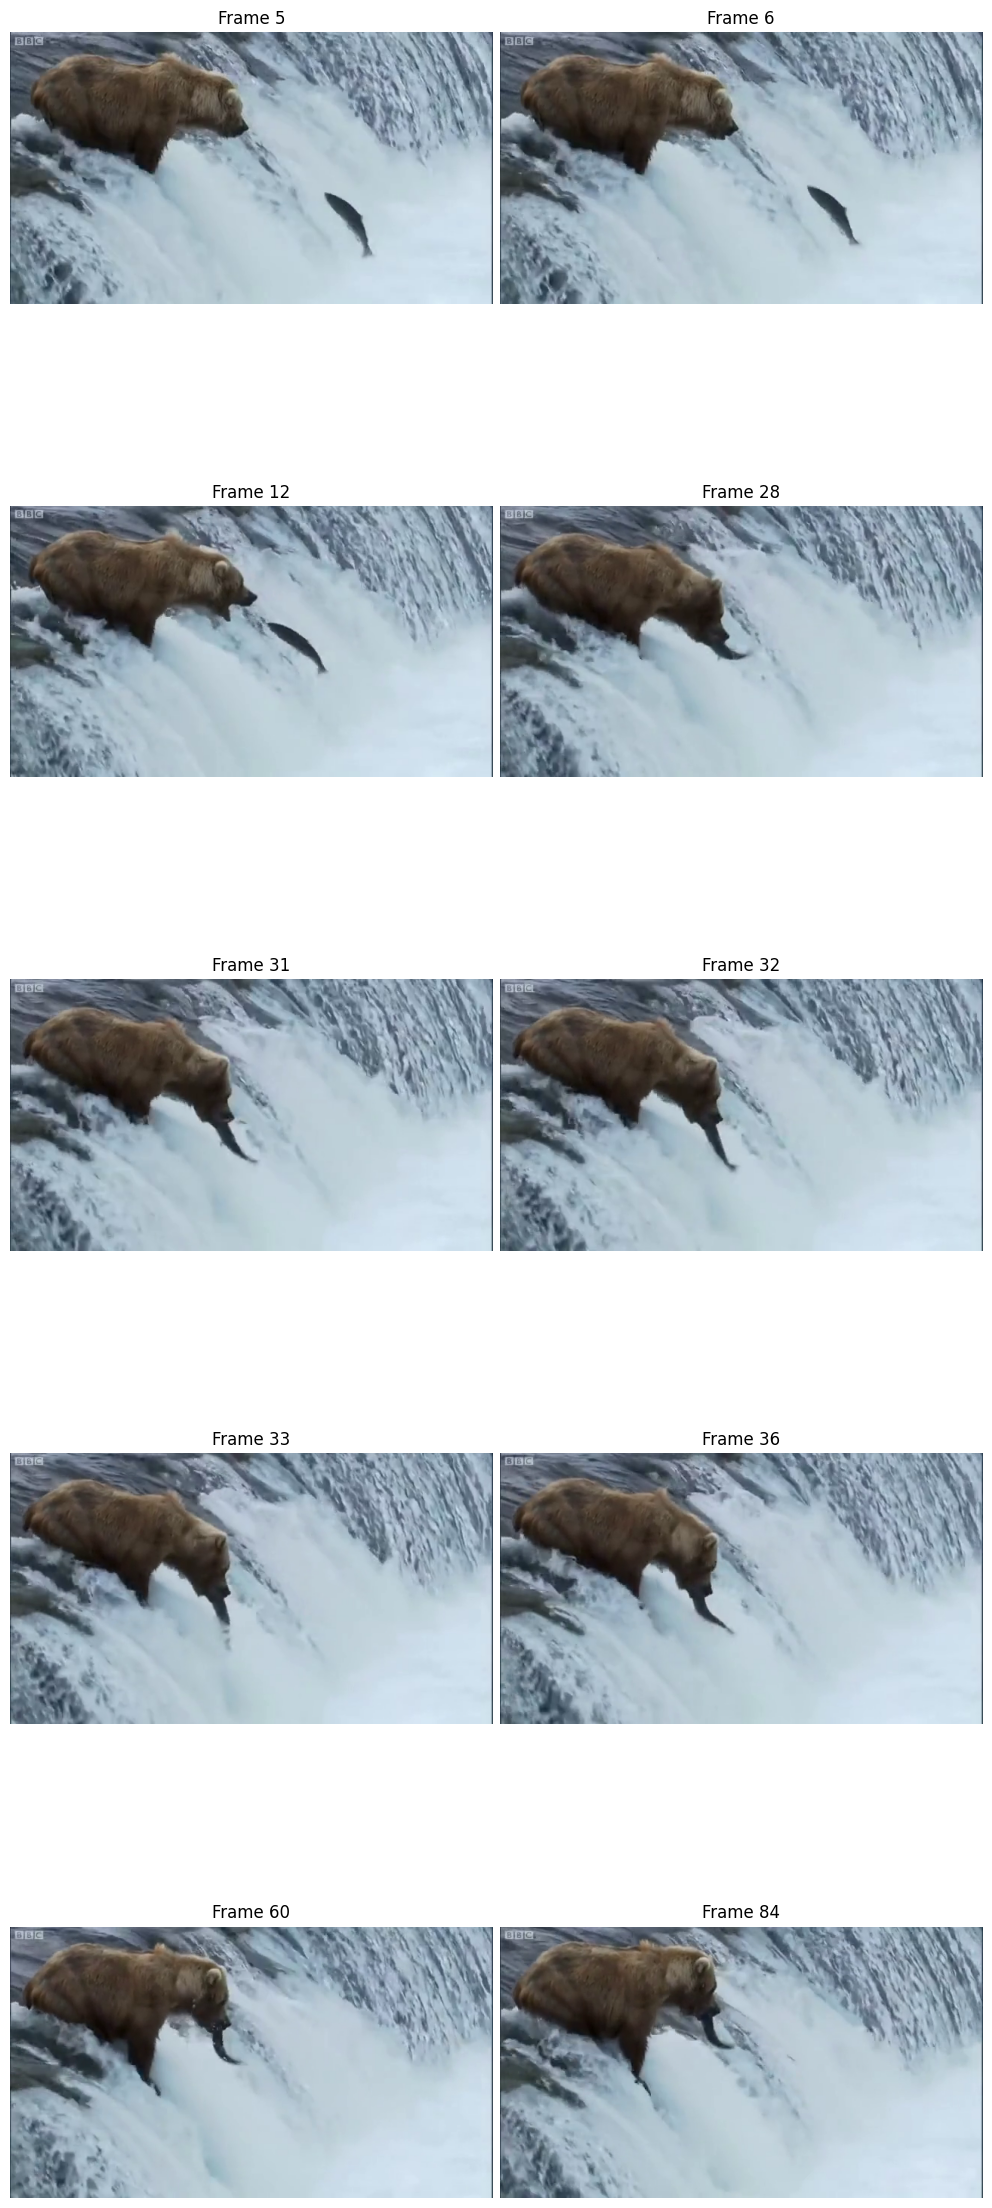

In [36]:
# Plotting the frames
num_frames = len(selected_frames)
num_columns = 2
num_rows = (num_frames + 1) // num_columns  # Calculate rows needed, +1 to handle odd number of frames

fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Display each frame
for i, frame in enumerate(selected_frames):
    ax = axes[i]
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(f"Frame {frame_indices[i]}")

# Turn off unused subplots if frames are less than slots in grid
if num_frames % num_columns != 0:
    for j in range(i + 1, num_rows * num_columns):
        axes[j].axis('off')  # Hide unused axes

plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=0.5)
plt.show()